## [Pytorch Forecasting | Temporal Fusion Transformer](https://www.kaggle.com/code/crustacean/pytorch-forecasting-temporal-fusion-transformer)

In [55]:
import numpy as np 
import pandas as pd
import datetime as dt
from catboost import CatBoostRegressor
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

import copy
from pathlib import Path
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [56]:
train = pd.read_csv('../../data/sales_train.csv')
test = pd.read_csv('../../data/sales_test.csv')
solution = pd.read_csv('../../data/solution.csv')
inv = pd.read_csv('../../data/inventory.csv')
cle = pd.read_csv('../../data/calendar.csv')
test_weights = pd.read_csv('../../data/test_weights.csv')
train = train.merge(inv,on=['warehouse','unique_id'],how='left')
train['unique_id_and_name'] = train['unique_id'].astype(str) + '_' + train['name']
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [57]:
nan_count = train.sales.isna().sum()
print(f"Number of NaN entries in 'sales': {nan_count}")
train = train.dropna(subset=['sales'])
nan_count_after = train.sales.isna().sum()
print(f"Number of NaN entries in 'sales' after dropping: {nan_count_after}")

Number of NaN entries in 'sales': 52
Number of NaN entries in 'sales' after dropping: 0


In [58]:
# add time index
min_time_idx = train['date'].min()
train['time_idx'] = (train['date'] - min_time_idx).dt.days
train['unique_id'] = train['unique_id'].astype(str).astype('category')
test['time_idx'] = (test['date'] - min_time_idx).dt.days
test['unique_id'] = test['unique_id'].astype(str).astype('category')
test['sales'] = 0.0
test = pd.concat([train, test], ignore_index=True)

In [59]:
test.time_idx.min()

0

In [60]:
max_prediction_length = 28
max_encoder_length = 28
training_cutoff = train["time_idx"].max() # - max_prediction_length

training = TimeSeriesDataSet(
    train, #[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["unique_id"],
    min_encoder_length=1, # max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[
        "unique_id",
        'warehouse',
    ],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[
        "time_idx",
        'total_orders',
        'sell_price_main',
        'type_0_discount',
        'type_1_discount',
        'type_2_discount',
        'type_3_discount',
        'type_4_discount',
        'type_5_discount',
        'type_6_discount',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'sales',
    ],
    target_normalizer=GroupNormalizer(
        groups=["unique_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0) # batch_size=batch_size * 10

In [61]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    loss=MAE(),
    log_interval=10,  
    optimizer="adamw",
)

trainer = pl.Trainer(
    max_epochs= 200, 
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 117.5k


In [62]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 86.3 K | train
3  | prescalers                         | ModuleDict                      | 240    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Epoch 199: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s, v_num=2, train_loss_step=17.80, val_loss=24.60, train_loss_epoch=22.40]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s, v_num=2, train_loss_step=17.80, val_loss=24.60, train_loss_epoch=22.40]


In [63]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [64]:
raw_predictions = best_tft.predict(test, 
                                   mode="raw", 
                                   return_x=True, 
                                   return_index=True,
                                  )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


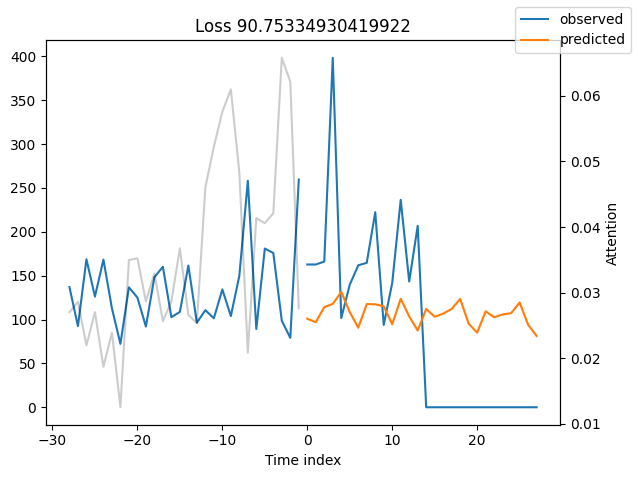

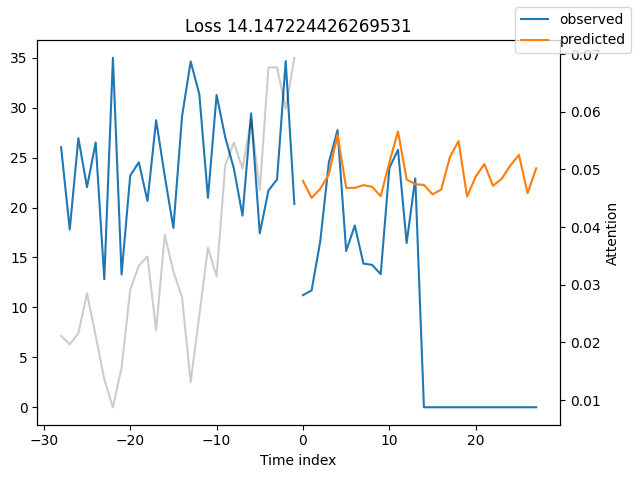

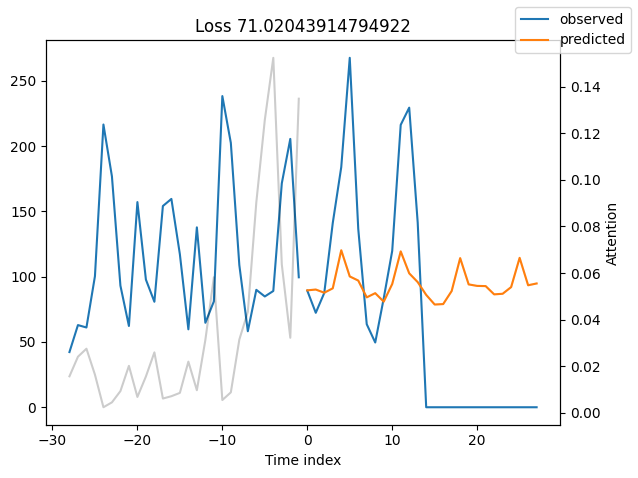

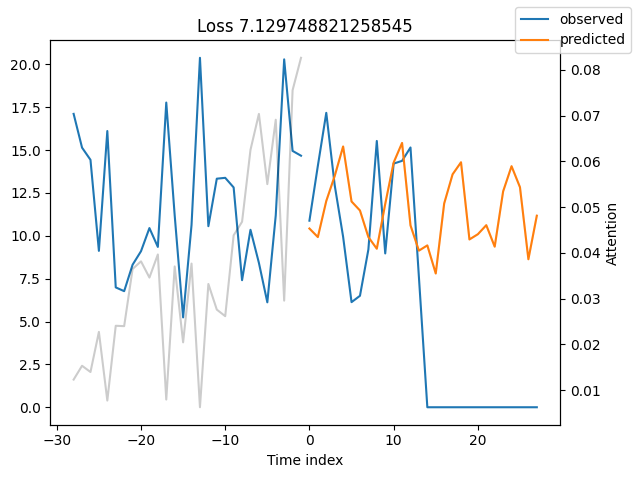

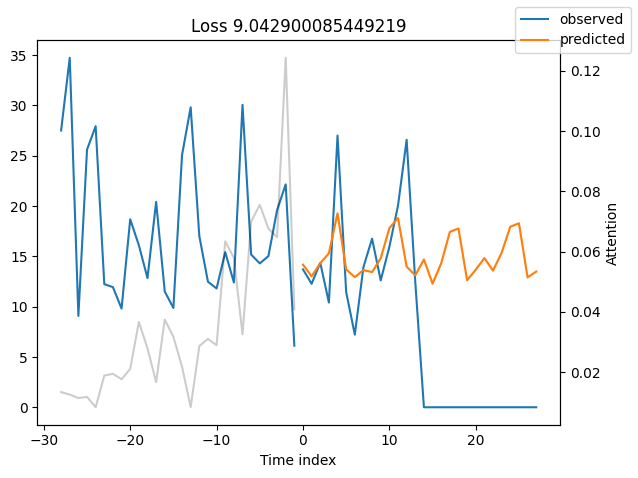

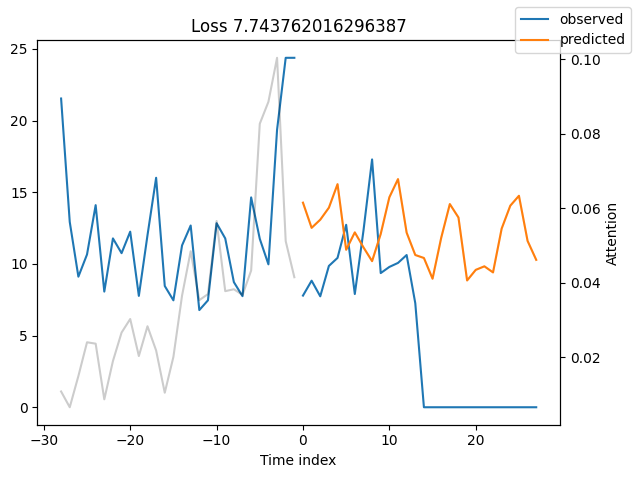

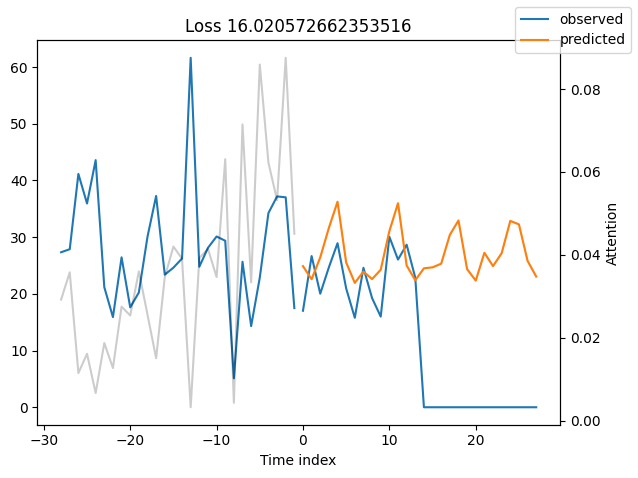

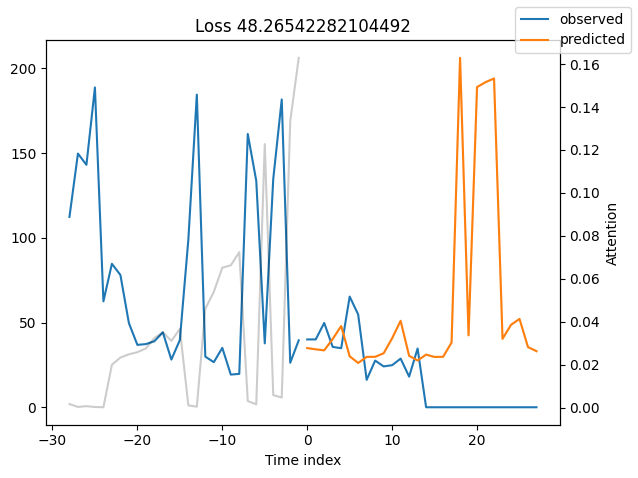

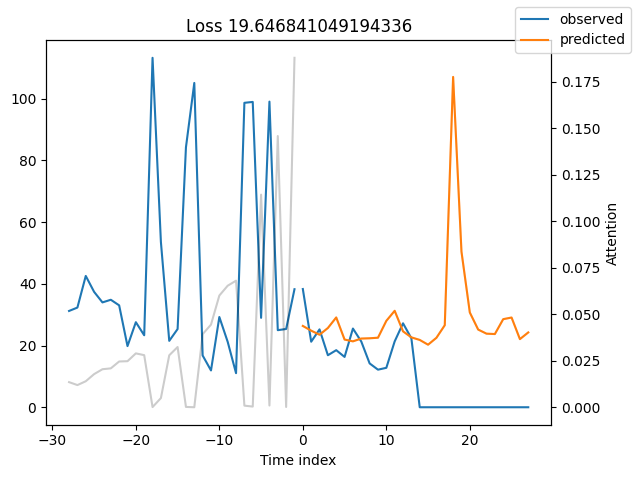

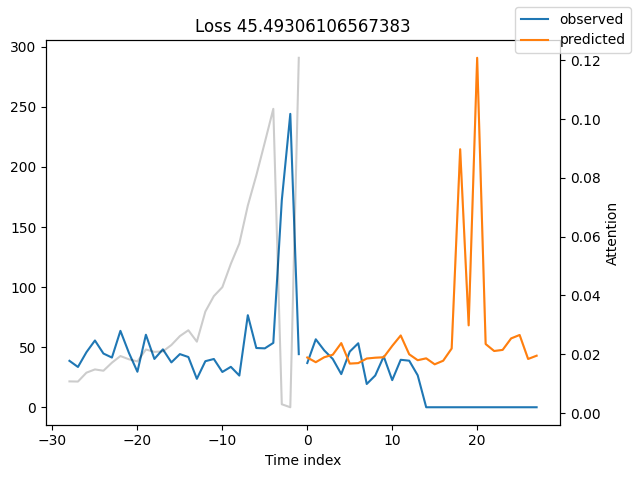

In [65]:
for idx in range(10):
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [66]:
pred_index = raw_predictions.index
preds = raw_predictions.output.prediction.cpu()

In [67]:
pred_index

,time_idx,unique_id
0,1388,1
1,1388,10
2,1388,100
3,1388,1001
4,1388,1002
...,...,...
4941,1388,995
4942,1388,996
4943,1388,997
4944,1388,998


In [68]:
preds.shape

torch.Size([4946, 28, 1])

In [69]:
pred_index.time_idx.count()

4946

In [70]:
solution = solution[['id']]

In [71]:
solution[['unique_id', 'date']] = solution['id'].str.split('_', expand=True)

In [72]:
train['date'].min()

Timestamp('2020-08-01 00:00:00')

In [73]:
solution['date'] = pd.to_datetime(solution['date'])
start_date = train['date'].min()
solution['time_idx'] = (solution['date'] - start_date).dt.days

In [74]:
solution

,id,unique_id,date,time_idx
0,1226_2024-06-03,1226,2024-06-03,1402
1,1226_2024-06-11,1226,2024-06-11,1410
2,1226_2024-06-13,1226,2024-06-13,1412
3,1226_2024-06-15,1226,2024-06-15,1414
4,1226_2024-06-09,1226,2024-06-09,1408
...,...,...,...,...
47016,4572_2024-06-03,4572,2024-06-03,1402
47017,3735_2024-06-04,3735,2024-06-04,1403
47018,3735_2024-06-03,3735,2024-06-03,1402
47019,2129_2024-06-03,2129,2024-06-03,1402


In [75]:
preds = preds.squeeze(-1).numpy()
horizon = preds.shape[1]
pred_index["forecast_idx"] = range(len(pred_index)) 
expanded_forecasts = []

for idx, row in pred_index.iterrows():
    start_time_idx = row["time_idx"]
    unique_id = row["unique_id"]
    forecast_values = preds[idx]
    time_indices = np.arange(start_time_idx, start_time_idx + horizon)
    
    expanded_forecasts.append(pd.DataFrame({
        "time_idx": time_indices,
        "unique_id": unique_id,
        "sales_hat": forecast_values
    }))

expanded_forecasts_df = pd.concat(expanded_forecasts, ignore_index=True)

solution = solution.merge(expanded_forecasts_df, on=["unique_id", "time_idx"], how="left")

In [76]:
solution

,id,unique_id,date,time_idx,sales_hat
0,1226_2024-06-03,1226,2024-06-03,1402,19.243210
1,1226_2024-06-11,1226,2024-06-11,1410,73.423866
2,1226_2024-06-13,1226,2024-06-13,1412,86.105125
3,1226_2024-06-15,1226,2024-06-15,1414,70.327057
4,1226_2024-06-09,1226,2024-06-09,1408,17.540693
...,...,...,...,...,...
47016,4572_2024-06-03,4572,2024-06-03,1402,56.073467
47017,3735_2024-06-04,3735,2024-06-04,1403,147.102051
47018,3735_2024-06-03,3735,2024-06-03,1402,157.807800
47019,2129_2024-06-03,2129,2024-06-03,1402,513.985229


In [77]:
solution.isna().sum()

id              0
unique_id       0
date            0
time_idx        0
sales_hat    1335
dtype: int64

In [78]:
solution[solution['sales_hat'].isna()]

,id,unique_id,date,time_idx,sales_hat
693,3715_2024-06-12,3715,2024-06-12,1411,NaN
694,3715_2024-06-13,3715,2024-06-13,1412,NaN
695,3715_2024-06-11,3715,2024-06-11,1410,NaN
696,3715_2024-06-16,3715,2024-06-16,1415,NaN
697,3715_2024-06-14,3715,2024-06-14,1413,NaN
...,...,...,...,...,...
46967,1718_2024-06-12,1718,2024-06-12,1411,NaN
46968,1718_2024-06-16,1718,2024-06-16,1415,NaN
46969,1718_2024-06-14,1718,2024-06-14,1413,NaN
46970,1718_2024-06-15,1718,2024-06-15,1414,NaN
